In [2]:
import os
os.chdir('W:\YOLOv3')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

In [4]:
model = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

In [88]:
# with open('coco.names') as cls:
#     classes = [line.strip() for line in cls.readlines()]
# classes

with open('coco.names') as cls:
    classes = cls.read().strip().split('\n')
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [6]:
len(classes)

80

In [7]:
layer_names = model.getLayerNames()
len(layer_names)

254

In [8]:
layer_names[:13]

('conv_0',
 'bn_0',
 'leaky_1',
 'conv_1',
 'bn_1',
 'leaky_2',
 'conv_2',
 'bn_2',
 'leaky_3',
 'conv_3',
 'bn_3',
 'leaky_4',
 'shortcut_4')

In [9]:
output_layers = model.getUnconnectedOutLayers()-1
output_layers

array([199, 226, 253])

In [10]:
output_layers_names = [layer_names[n] for n in output_layers]
output_layers_names

['yolo_82', 'yolo_94', 'yolo_106']

In [155]:
# img = cv2.cvtColor(cv2.imread('horse.jpg'), cv2.COLOR_BGR2RGB)
img = cv2.imread('horse.jpg')

In [96]:
def cvimshow(img, wn='yolo'):
    cv2.imshow(wn, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def imshow(img_array):
    print('\n'*4, '\t'*3, img_array.shape, end='\n')
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()

In [13]:
cvimshow(img)





 			 (375, 500, 3)


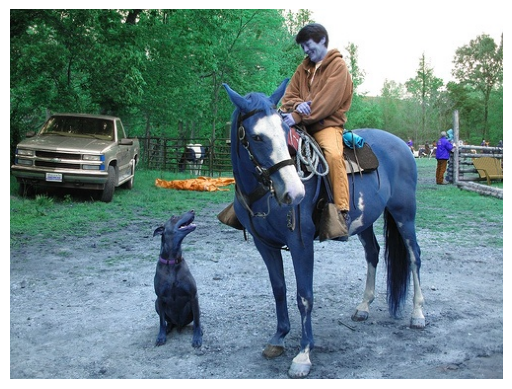

In [126]:
imshow(img)

In [98]:
blob = cv2.dnn.blobFromImage(image=img, scalefactor=1/255, size=(416, 416),
                                      mean=(0, 0, 0), swapRB=True, crop=False)

**You can read the doc of this function from [here](https://pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/)**

In [99]:
t0 = time.time()

model.setInput(blob)
outputs = model.forward(output_layers_names)
len(outputs)

print(f'Elapsed time: {time.time()-t0} Sec')

Elapsed time: 1.1103742122650146 Sec


In [100]:
for out in outputs:
    print(out.shape)

(507, 85)
(2028, 85)
(8112, 85)


**(bounding_boxes) x (bbox_coordinates(cx, cy, w, h)+conf+classes)**

In [101]:
blob.shape

(1, 3, 416, 416)

In [138]:
height, width = img.shape[:-1]

bboxes = []
# confs = []
scores = []
cls_ids = []

In [139]:
for res in outputs:
    for obj in res:
        cls_id = np.argmax(obj[5:])
        score = obj[5:][cls_id]
        #conf = obj[4]
        x, y, w, h = obj[:4]
        
        if score>0.4:
            # confs.append(conf)
            scores.append(score)
            cls_ids.append(cls_id)
            
            cx = int(obj[0]*width)
            cy = int(obj[1]*height)
            
            w = int(obj[2]*width)
            h = int(obj[3]*height)
            
            x = int(cx-w/2)
            y = int(cy-h/2)
            
            bboxes.append([x, y, w, h])

In [140]:
print(len(bboxes))
len(bboxes)==len(confs)==len(cls_ids)

25


True

In [176]:
img_copy = img.copy()

In [177]:
for bb in range(len(bboxes)):
    x, y, w, h = bboxes[bb]
    cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)





 			 (375, 500, 3)


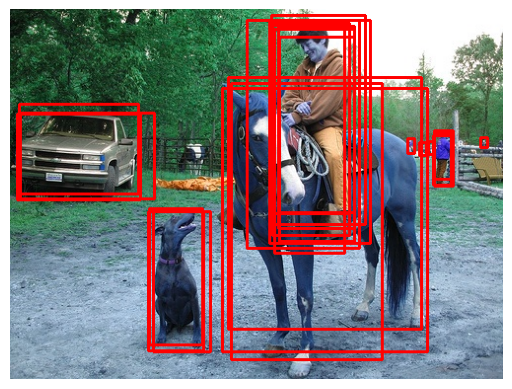

In [178]:
imshow(img_copy)

In [204]:
idxs = cv2.dnn.NMSBoxes(bboxes=bboxes, scores=scores, score_threshold=.8, nms_threshold=.2)
print(len(idxs))
idxs

6


array([ 8, 12, 15, 16,  4, 20])

In [208]:
img_copy2 = img.copy()
font = cv2.FONT_HERSHEY_SIMPLEX
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint32')

In [209]:
for i in idxs:
    x, y, w, h = bboxes[i]
    cv2.rectangle(img_copy2, (x, y), (x+w, y+h), (255, 0, 0), 2)
    label = str(classes[cls_ids[i]])
    color = [int(c) for c in colors[cls_ids[i]]]
    text = "{}: {:.4f}".format(classes[cls_ids[i]], scores[i])
    cv2.putText(img_copy2, text, (x+1, y - 5), font, 0.6, color, 1)





 			 (375, 500, 3)


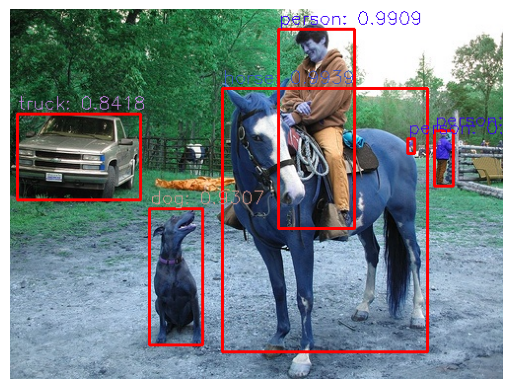

In [210]:
imshow(img_copy2)